In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve

In [2]:
M=1000
ite=20
dim_n=5
T=1
delta = torch.tensor(T/ite)
#delta=torch.tensor(0.01)
sigma=0.2
sigma1=0.01
sigma2=0.01
theta1=0.2
theta2=0.2
mu1=1
mu2=3
A0=0.0
gamma=0.0
X0=1000
neuron_model_psi=20
print(delta)

tensor(0.0500)


In [3]:
model= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),   torch.nn.ReLU(),
#   
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [4]:
def kappa_rho_sim(M,ite,theta1,mu1,sigma1,theta2,mu2,sigma2):
    kappa=torch.zeros([M,ite+1])
    kappa[:,0]=0.3
    rho=torch.zeros([M,ite+1])
    rho[:,0]=1.0

    for i in range (1,ite+1):
        kappa[:,i]=kappa[:,i-1]+theta1*(mu1-kappa[:,i-1])*delta+np.sqrt(delta)*sigma1*np.random.rand(M)  # Xn+1=Xn+θ(μ−Xn)Δt+σΔWn
        rho[:,i]=rho[:,i-1]+theta2*(mu2-rho[:,i-1])*delta+sigma2*np.random.rand(M)
    return kappa,rho

In [5]:
t=torch.zeros([M,1])
D=torch.zeros([M,1])
kappa,rho=kappa_rho_sim(M,ite,theta1,mu1,sigma1,theta2,mu2,sigma2)
R=torch.FloatTensor(M,1).uniform_(X0*0.9,X0*1.1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t


In [6]:
print('kappa=',kappa,'\n rho=',rho) 
x=torch.cat((t,D,R,kappa[:,0].unsqueeze(1),rho[:,0].unsqueeze(1)),dim=1)

kappa= tensor([[0.3000, 0.3077, 0.3163,  ..., 0.4338, 0.4408, 0.4485],
        [0.3000, 0.3079, 0.3152,  ..., 0.4334, 0.4406, 0.4479],
        [0.3000, 0.3091, 0.3162,  ..., 0.4363, 0.4428, 0.4505],
        ...,
        [0.3000, 0.3071, 0.3149,  ..., 0.4338, 0.4403, 0.4476],
        [0.3000, 0.3078, 0.3164,  ..., 0.4325, 0.4385, 0.4459],
        [0.3000, 0.3084, 0.3174,  ..., 0.4324, 0.4397, 0.4462]]) 
 rho= tensor([[1.0000, 1.0206, 1.0457,  ..., 1.3912, 1.4141, 1.4383],
        [1.0000, 1.0238, 1.0451,  ..., 1.4191, 1.4376, 1.4562],
        [1.0000, 1.0260, 1.0464,  ..., 1.4029, 1.4243, 1.4491],
        ...,
        [1.0000, 1.0248, 1.0466,  ..., 1.4092, 1.4276, 1.4501],
        [1.0000, 1.0240, 1.0469,  ..., 1.4046, 1.4289, 1.4466],
        [1.0000, 1.0259, 1.0525,  ..., 1.4234, 1.4419, 1.4586]])


In [7]:
def update(x3,psi,i):
  t=(x3[:,0]+(1/ite))
  kap=kappa[:,i+1]
  rh=rho[:,i+1]
#   kappa=x3[:,3]+theta1*(mu1-x3[:,3])*delta+torch.sqrt(delta)*sigma1*W1[i]
#   rho=x3[:,4]+theta2*(mu2-x3[:,4])*delta+torch.sqrt(delta)*sigma1*W2[i]
  D = (x3[:,1]+kap*psi)*torch.exp(-rh*delta)
  #print('d',D.shape)
  R= x3[:,2]-psi
  #print(kappa.shape,rho.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1),kap.unsqueeze(1),rh.unsqueeze(1)),dim=1)
  return up

def loss_func(x2,psi):
  loss=(x2[:,1]*psi+(x2[:,3]/2.0)*torch.pow(psi,2))
  #print('loss',loss.shape)
  return loss

def unit(x1,model,i):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,i)
    #print(upd)
    return psi,los,upd

def loss_func_total(u,model):
  loss=torch.zeros(M,ite)
  psi=torch.zeros(M,ite)
  for i in range(ite+1):
    if(i!=ite):
      psi_run,loss_run,u_run=unit(u,model,i)
      #print('los func=',psi_run.shape,loss_run.shape)
      loss[:,i]=loss_run
      #print(loss)
      psi[:,i]=psi_run
      #print(psi)
      u=u_run
      #print(u)
    else:
      #print(torch.sum(psi,dim=1),R.squeeze(1))
      psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
      loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  loss=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss)

In [8]:
start=time.time()
lr1 = 8e-3
max_epoch = 10000
optimizer = optim.Adam(model.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(x,model)
  cost.backward()
  optimizer.step()
  #print(loss.item())
  if (epoch % 100==0):
    print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
end=time.time()
print('time elapsed=',end-start)

At epoch 0 the mean cost is 122458.53125.
At epoch 100 the mean cost is 107376.640625.
At epoch 200 the mean cost is 107203.7578125.
At epoch 300 the mean cost is 107130.765625.
At epoch 400 the mean cost is 107043.5390625.
At epoch 500 the mean cost is 106883.6015625.
At epoch 600 the mean cost is 106647.3671875.
At epoch 700 the mean cost is 106576.515625.
At epoch 800 the mean cost is 106572.75.
At epoch 900 the mean cost is 106571.8203125.
At epoch 1000 the mean cost is 106571.28125.
At epoch 1100 the mean cost is 106570.6953125.
At epoch 1200 the mean cost is 106572.703125.
At epoch 1300 the mean cost is 106574.953125.
At epoch 1400 the mean cost is 106568.9296875.
At epoch 1500 the mean cost is 106570.875.
At epoch 1600 the mean cost is 106568.75.
At epoch 1700 the mean cost is 106567.8203125.
At epoch 1800 the mean cost is 106567.71875.
At epoch 1900 the mean cost is 106568.515625.
At epoch 2000 the mean cost is 106565.5078125.
At epoch 2100 the mean cost is 106567.1484375.
At e

In [9]:
def cost(y):
  cost1=0.0
  D1=0.0
  for i in range(ite+1):
    cost1+=D1*y[i]+(kappa/2.0)*np.power(y[i],2)
    D1=(D1+kappa*y[i])*np.exp(-rho*T/ite)
  return cost1

In [10]:
from torch.nn.modules.pooling import MaxPool1d
M1=10
t_test=torch.zeros([M1,1])
D_test=torch.zeros([M1,1])
#D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
#R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
R_test=torch.linspace(X0*0.95, X0*1.05, steps=M1).unsqueeze(1)
kappa,rho=kappa_rho_sim(M1,ite,0.1,mu1,sigma1,0.1,mu2,sigma2)
x_test=torch.cat((t_test,D_test,R_test,kappa[:,0].unsqueeze(1),rho[:,0].unsqueeze(1)),dim=1)
print('Input=',x_test,'\n')
a=torch.zeros(M1,ite+1)
#print(a.shape)
for i in range(ite+1):
  if(i!=ite):
    #print(x_test)
    soln_pred=model(x_test).squeeze(1).detach()
    a[:,i]=soln_pred
    x_test=update(x_test,soln_pred,i)
    #print(x_test,'\n')
  else:
    a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)

x1=R_test.squeeze().numpy()
c_pred=np.zeros(M1)

for i in range(M1):
  print('size of total order=',x1[i])


  print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
  pred_cost=cost(a[i,:].detach().numpy())
#   print('predicted cost=',pred_cost,'\n')

Input= tensor([[0.0000e+00, 0.0000e+00, 9.5000e+02, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 9.6111e+02, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 9.7222e+02, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 9.8333e+02, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 9.9444e+02, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0056e+03, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0167e+03, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0278e+03, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0389e+03, 3.0000e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0500e+03, 3.0000e-01, 1.0000e+00]]) 

size of total order= 950.0
predicted soln= tensor([ 564.0912, -186.5289,   97.6586,  -14.8254,   30.6514,   11.6448,
          19.6319,   16.0072,   17.5210,   16.7978,   16.9678,   16.7862,
          16.7935,   16.6970,   16.6161,   16.5685,   16.5008,   16.4480,
          16.4924,   16.3

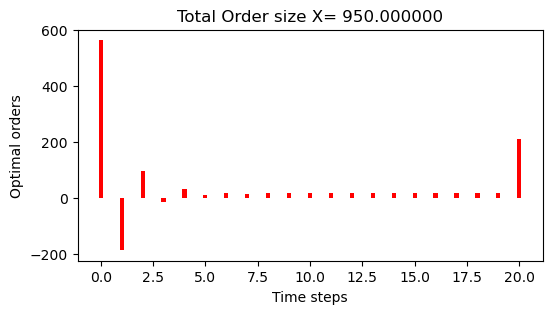

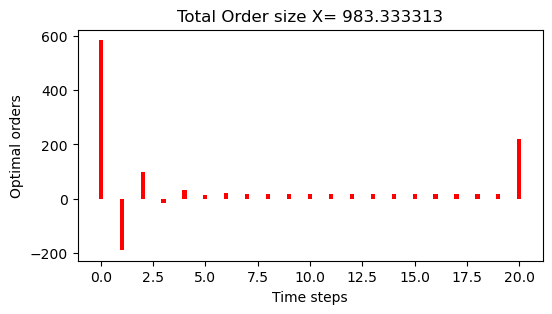

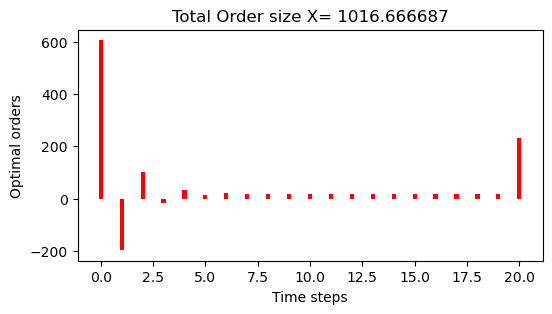

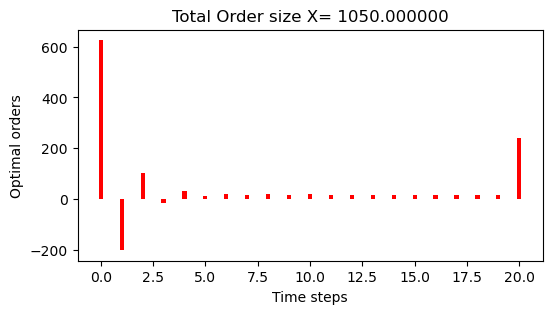

In [14]:
p_soln=a.numpy()
t_step=np.linspace(0,ite,num=ite+1)
#name='E:/Robin research/7thECMF_PosterPresent/Figures/N.eps'
def plotting(t):
  #print('Total order size=',x1[t],np.sum(n_soln[t]),np.sum(p_soln[t]))
  #print(n_soln[t],p_soln[t])
  plt.figure(figsize=(6,3))
  #plt.bar(t_step,t_soln[t],color='blue',width=0.3,label='Closed-Form')
  plt.bar(t_step,p_soln[t],color='red',width=0.2)
  #plt.bar(t_step,n_soln[t],color='green',width=0.1,label='numeric')
  plt.title('Total Order size X= %f' % (x1[t]))
  plt.xlabel('Time steps')
  plt.ylabel('Optimal orders')
  #plt.legend()

#   #plt.savefig('f.eps', format='eps')
#   if(t==0):
#     plt.savefig(name,format='eps')      
  plt.show()
for i in range(0,M1,3):
  plotting(i)

In [12]:
print(kappa)

tensor([[0.3000, 0.3056, 0.3105, 0.3141, 0.3189, 0.3245, 0.3283, 0.3333, 0.3376,
         0.3429, 0.3478, 0.3517, 0.3556, 0.3605, 0.3656, 0.3698, 0.3747, 0.3780,
         0.3816, 0.3862, 0.3912],
        [0.3000, 0.3051, 0.3088, 0.3131, 0.3188, 0.3238, 0.3289, 0.3332, 0.3386,
         0.3421, 0.3462, 0.3505, 0.3547, 0.3599, 0.3634, 0.3673, 0.3712, 0.3750,
         0.3792, 0.3843, 0.3874],
        [0.3000, 0.3057, 0.3105, 0.3159, 0.3205, 0.3253, 0.3292, 0.3330, 0.3382,
         0.3429, 0.3463, 0.3501, 0.3551, 0.3590, 0.3638, 0.3680, 0.3729, 0.3760,
         0.3809, 0.3853, 0.3901],
        [0.3000, 0.3044, 0.3080, 0.3133, 0.3173, 0.3212, 0.3259, 0.3312, 0.3357,
         0.3404, 0.3443, 0.3487, 0.3529, 0.3575, 0.3618, 0.3665, 0.3713, 0.3767,
         0.3801, 0.3847, 0.3884],
        [0.3000, 0.3037, 0.3077, 0.3126, 0.3173, 0.3221, 0.3266, 0.3320, 0.3354,
         0.3389, 0.3423, 0.3457, 0.3506, 0.3541, 0.3574, 0.3621, 0.3674, 0.3716,
         0.3749, 0.3794, 0.3828],
        [0.3000, 0.3

In [13]:
print(rho)

tensor([[1.0000, 1.0151, 1.0329, 1.0517, 1.0682, 1.0858, 1.0956, 1.1070, 1.1192,
         1.1384, 1.1480, 1.1598, 1.1722, 1.1856, 1.1974, 1.2103, 1.2237, 1.2347,
         1.2526, 1.2666, 1.2812],
        [1.0000, 1.0125, 1.0303, 1.0464, 1.0638, 1.0799, 1.0949, 1.1050, 1.1161,
         1.1314, 1.1460, 1.1607, 1.1726, 1.1819, 1.2002, 1.2112, 1.2257, 1.2376,
         1.2558, 1.2687, 1.2780],
        [1.0000, 1.0149, 1.0300, 1.0400, 1.0540, 1.0708, 1.0880, 1.1009, 1.1156,
         1.1327, 1.1426, 1.1534, 1.1690, 1.1851, 1.1968, 1.2143, 1.2311, 1.2446,
         1.2632, 1.2816, 1.2938],
        [1.0000, 1.0166, 1.0313, 1.0416, 1.0535, 1.0662, 1.0839, 1.0969, 1.1089,
         1.1199, 1.1358, 1.1479, 1.1656, 1.1824, 1.1973, 1.2070, 1.2170, 1.2339,
         1.2446, 1.2614, 1.2798],
        [1.0000, 1.0188, 1.0324, 1.0453, 1.0555, 1.0709, 1.0888, 1.1076, 1.1217,
         1.1311, 1.1444, 1.1628, 1.1742, 1.1841, 1.1954, 1.2100, 1.2192, 1.2330,
         1.2501, 1.2619, 1.2730],
        [1.0000, 1.0